# Load libary

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor,StackingRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence

from xgboost import XGBRFRegressor,XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# import keras
# import tensorflow

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras import regularizers
# from keras.callbacks import EarlyStopping

from mypipes import *

import warnings
warnings.filterwarnings('ignore') # ignore the warnings.

import seaborn as sb
import matplotlib.pyplot as plt
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.6f} (std: {1:.6f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def Threshold_Finder(Y_test,Y_predict):
    I = []
    roc_ = []
    for i in np.linspace(0.01,1,1000):
        Y_predict = Y_predict_prob[:,1] > i
        roc = roc_auc_score(Y_test,Y_predict)
        I.append(i)
        roc_.append(roc)
    Temp = I[roc_.index(max(roc_))]
    return Temp

# Load the data frame

In [2]:
train_file = r'emissions.csv'
ld_train = pd.read_csv(train_file)

In [3]:
# overview of data
ld_train.head(10)

,ppm,eng_sp1,eng_sp2,eng_sp3,eng_sp4,eng_sp5,fuel_sp1,fuel_sp2,fuel_sp3,fuel_sp4,...,gear_sp1,gear_sp2,gear_sp3,gear_sp4,gear_sp5,nav_sp1,nav_sp2,nav_sp3,nav_sp4,nav_sp5
0,1328.33,1.65,1.79,2.51,6.88,5.47,6.99,10.13,19.84,4.69,...,5.09,29.09,6.38,22.57,5.35,9.02,12.05,9.21,-7.03,8.147418
1,1302.89,0.55,3.45,5.33,7.77,7.75,-1.03,2.98,11.73,8.55,...,5.75,-18.82,-3.23,33.90,10.29,6.86,14.64,9.74,52.65,-1.550768
2,1717.24,1.26,3.74,3.76,2.71,-5.08,3.60,8.79,11.02,-10.50,...,34.46,18.26,17.17,20.72,-6.71,2.74,22.37,28.08,51.19,60.725525
3,1348.27,0.83,-0.64,1.72,6.93,8.79,19.60,-5.28,2.36,4.67,...,16.20,15.01,-12.50,45.63,-14.29,17.98,20.84,9.58,-12.53,34.242919
4,1315.34,1.68,-1.36,-2.31,1.84,-3.10,6.31,-3.94,3.95,4.74,...,4.71,12.47,16.02,28.17,41.41,-10.97,38.04,12.19,-11.89,55.571175
5,1289.92,1.46,0.63,1.94,13.16,11.46,19.52,7.03,5.53,15.36,...,10.55,9.52,7.48,6.15,32.00,26.08,23.66,46.80,8.52,46.718019
6,1272.86,0.52,1.98,-1.08,6.80,0.25,4.98,6.30,5.71,15.33,...,8.73,3.71,30.24,12.13,17.91,26.17,23.90,45.79,12.33,30.322607
7,1335.97,1.65,3.17,0.09,7.09,-2.32,6.26,-1.83,-0.61,-3.27,...,17.34,18.56,11.41,17.98,22.59,-7.51,6.35,9.83,28.60,29.688727
8,1308.73,0.61,1.75,6.28,5.60,5.85,-5.58,18.14,15.23,12.13,...,11.04,17.63,24.48,29.56,27.65,-3.25,7.46,-1.18,21.12,21.968921
9,1227.95,-1.25,2.68,3.76,6.42,10.60,1.05,-2.72,6.97,17.25,...,1.71,5.27,45.79,2.84,34.33,15.48,0.86,-12.73,10.52,8.656411


In [4]:
# get to know data type
ld_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ppm       10000 non-null  float64
 1   eng_sp1   10000 non-null  float64
 2   eng_sp2   10000 non-null  float64
 3   eng_sp3   10000 non-null  float64
 4   eng_sp4   10000 non-null  float64
 5   eng_sp5   10000 non-null  float64
 6   fuel_sp1  10000 non-null  float64
 7   fuel_sp2  10000 non-null  float64
 8   fuel_sp3  10000 non-null  float64
 9   fuel_sp4  10000 non-null  float64
 10  fuel_sp5  10000 non-null  float64
 11  gear_sp1  10000 non-null  float64
 12  gear_sp2  10000 non-null  float64
 13  gear_sp3  10000 non-null  float64
 14  gear_sp4  10000 non-null  float64
 15  gear_sp5  10000 non-null  float64
 16  nav_sp1   10000 non-null  float64
 17  nav_sp2   10000 non-null  float64
 18  nav_sp3   10000 non-null  float64
 19  nav_sp4   10000 non-null  float64
 20  nav_sp5   10000 non-null  flo

In [5]:
# data is clean
y_ld_train = ld_train['ppm']
x_ld_train = ld_train.drop(['ppm'],axis = 1)

In [6]:
x_ld_train.describe()

,eng_sp1,eng_sp2,eng_sp3,eng_sp4,eng_sp5,fuel_sp1,fuel_sp2,fuel_sp3,fuel_sp4,fuel_sp5,gear_sp1,gear_sp2,gear_sp3,gear_sp4,gear_sp5,nav_sp1,nav_sp2,nav_sp3,nav_sp4,nav_sp5
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.002010,1.956886,2.976934,3.967121,4.946834,6.113373,7.077916,8.050440,8.864605,10.025374,11.041913,11.914443,12.860342,14.114776,14.891077,16.063005,16.952261,17.828016,18.808888,20.065645
std,1.002768,1.988977,2.985987,3.998752,4.980739,5.945187,7.001859,7.997358,9.012590,9.939473,10.957708,12.050839,12.983140,14.015704,15.183466,15.934252,16.929151,18.000507,19.092010,19.758487
min,-2.920000,-5.610000,-8.360000,-11.460000,-13.900000,-18.630000,-19.330000,-21.060000,-27.260000,-23.730000,-31.210000,-35.200000,-40.640000,-34.130000,-38.270000,-42.180000,-40.800000,-48.510000,-55.850000,-60.928110
25%,0.330000,0.600000,0.980000,1.240000,1.540000,2.160000,2.350000,2.580000,2.720000,3.310000,3.790000,3.777500,4.050000,4.590000,4.660000,5.517500,5.487500,5.740000,6.070000,6.958470
50%,1.010000,1.980000,2.980000,3.970000,4.990000,6.130000,7.030000,8.030000,8.900000,10.010000,11.155000,12.010000,12.880000,13.830000,14.860000,15.910000,17.010000,18.100000,18.795000,19.893075
75%,1.680000,3.310000,5.010000,6.730000,8.302500,10.142500,11.750000,13.572500,14.940000,16.690000,18.340000,19.920000,21.640000,23.710000,25.180000,26.685000,28.562500,29.980000,31.660000,33.449892
max,5.110000,10.270000,14.960000,20.770000,23.750000,30.350000,33.360000,34.350000,42.070000,42.620000,55.790000,61.670000,60.980000,69.840000,83.210000,74.270000,76.530000,88.530000,97.150000,90.704278


In [7]:
y_ld_train.describe()

count    10000.000000
mean      1326.003137
std        115.898260
min        583.670000
25%       1281.247500
50%       1308.010000
75%       1348.502500
max       2978.270000
Name: ppm, dtype: float64

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(x_ld_train, y_ld_train, test_size=0.2, random_state=1)

In [9]:
Y_test =  pd.DataFrame(data = np.array(Y_test) , columns = ['Actual PPM Emission'])
Y_test

,Actual PPM Emission
0,1335.54
1,1309.59
2,1305.30
3,1345.38
4,1382.26
...,...
1995,1468.55
1996,1365.38
1997,1410.55
1998,1294.96


# Linear Regression


In [10]:
Lm_1 = LinearRegression()
Lm_1.fit(X_train,Y_train)

LinearRegression()

In [11]:
Y_predict = Lm_1.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [12]:
mean_absolute_error(Y_test,Y_predict)

48.28107463939683

In [13]:
mean_squared_error(Y_test,Y_predict)

5954.263602460796

In [14]:
r2_score(Y_test,Y_predict)

0.5854583342205716

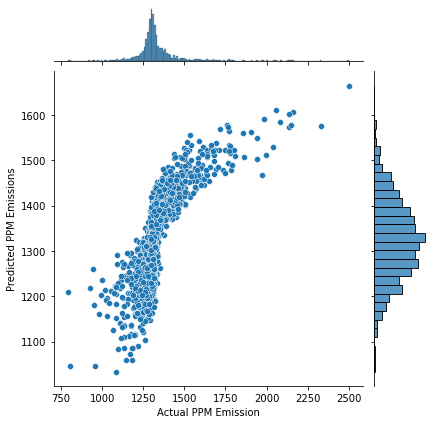

In [15]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# Lasso

In [16]:
alpha = np.linspace(0.01,100,100)
param_grid = {'alpha':alpha}

Lm_2 = Lasso()

random_search = RandomizedSearchCV(Lm_2,
                                   param_distributions = param_grid,
                                   n_iter = 25,
                                   cv = 5,
                                   scoring = 'r2' )

In [17]:
random_search.fit(X_train,Y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=25,
                   param_distributions={'alpha': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01, 2.122e+01, 2.223e+01, 2.324e+01,
       2.425e+01, 2.526e+01, 2....
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])},
                   scoring='r2')

In [18]:
random_search.best_estimator_

Lasso(alpha=5.06)

In [19]:
alpha = np.linspace(0.001,0.02,100)
param_grid = {'alpha':alpha}

Lm_2 = Lasso()

random_search = RandomizedSearchCV(Lm_2,
                                   param_distributions = param_grid,
                                   n_iter = 25,
                                   cv = 5,
                                   scoring = 'r2' )

In [20]:
random_search.fit(X_train,Y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=25,
                   param_distributions={'alpha': array([0.001     , 0.00119192, 0.00138384, 0.00157576, 0.00176768,
       0.0019596 , 0.00215152, 0.00234343, 0.00253535, 0.00272727,
       0.00291919, 0.00311111, 0.00330303, 0.00349495, 0.00368687,
       0.00387879, 0.00407071, 0.00426263, 0.00445455, 0.00464646,
       0.00483838, 0.0050303 , 0.00522222, 0.00541414, 0.005...
       0.01347475, 0.01366667, 0.01385859, 0.01405051, 0.01424242,
       0.01443434, 0.01462626, 0.01481818, 0.0150101 , 0.01520202,
       0.01539394, 0.01558586, 0.01577778, 0.0159697 , 0.01616162,
       0.01635354, 0.01654545, 0.01673737, 0.01692929, 0.01712121,
       0.01731313, 0.01750505, 0.01769697, 0.01788889, 0.01808081,
       0.01827273, 0.01846465, 0.01865657, 0.01884848, 0.0190404 ,
       0.01923232, 0.01942424, 0.01961616, 0.01980808, 0.02      ])},
                   scoring='r2')

In [21]:
random_search.best_estimator_

Lasso(alpha=0.019616161616161615)

In [22]:
alpha = np.linspace(0.001,0.02,50)
param_grid = {'alpha':alpha}

Lm_2 = Lasso()

grid_search = GridSearchCV(Lm_2,
                                   param_grid = param_grid,

                                   cv = 5,
                                       scoring = 'neg_mean_absolute_error' )

In [23]:
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.00138776, 0.00177551, 0.00216327, 0.00255102,
       0.00293878, 0.00332653, 0.00371429, 0.00410204, 0.0044898 ,
       0.00487755, 0.00526531, 0.00565306, 0.00604082, 0.00642857,
       0.00681633, 0.00720408, 0.00759184, 0.00797959, 0.00836735,
       0.0087551 , 0.00914286, 0.00953061, 0.00991837, 0.01030612,
       0.01069388, 0.01108163, 0.01146939, 0.01185714, 0.0122449 ,
       0.01263265, 0.01302041, 0.01340816, 0.01379592, 0.01418367,
       0.01457143, 0.01495918, 0.01534694, 0.01573469, 0.01612245,
       0.0165102 , 0.01689796, 0.01728571, 0.01767347, 0.01806122,
       0.01844898, 0.01883673, 0.01922449, 0.01961224, 0.02      ])},
             scoring='neg_mean_absolute_error')

In [24]:
Lasso_model = grid_search.best_estimator_

In [25]:
Lasso_model.fit(X_train,Y_train)
Y_predict = Lasso_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [26]:
mean_absolute_error(Y_test,Y_predict)

48.27860893142916

In [27]:
mean_squared_error(Y_test,Y_predict)

5954.0430282708385

In [28]:
r2_score(Y_test,Y_predict)

0.5854736908117872

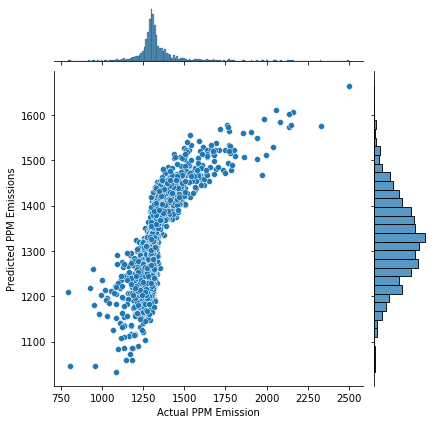

In [29]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# Ridge

In [30]:
alpha = np.linspace(150,3500,100)
param_grid = {'alpha':alpha}

Lm_3 = Ridge()

grid_search = GridSearchCV(Lm_3,
                                   param_grid = param_grid,
                                   cv = 5,
                                   scoring = 'r2' )


In [31]:
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 150.        ,  183.83838384,  217.67676768,  251.51515152,
        285.35353535,  319.19191919,  353.03030303,  386.86868687,
        420.70707071,  454.54545455,  488.38383838,  522.22222222,
        556.06060606,  589.8989899 ,  623.73737374,  657.57575758,
        691.41414141,  725.25252525,  759.09090909,  792.92929293,
        826.76767677,  860.60606061,  894.444444...
       2586.36363636, 2620.2020202 , 2654.04040404, 2687.87878788,
       2721.71717172, 2755.55555556, 2789.39393939, 2823.23232323,
       2857.07070707, 2890.90909091, 2924.74747475, 2958.58585859,
       2992.42424242, 3026.26262626, 3060.1010101 , 3093.93939394,
       3127.77777778, 3161.61616162, 3195.45454545, 3229.29292929,
       3263.13131313, 3296.96969697, 3330.80808081, 3364.64646465,
       3398.48484848, 3432.32323232, 3466.16161616, 3500.        ])},
             scoring='r2')

In [32]:
grid_search.best_estimator_

Ridge(alpha=3500.0)

In [33]:
Rigge_model = grid_search.best_estimator_
Rigge_model.fit(X_train,Y_train)

Ridge(alpha=3500.0)

In [34]:
Y_predict = Rigge_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [35]:
mean_absolute_error(Y_test,Y_predict)

48.177177183361636

In [36]:
mean_squared_error(Y_test,Y_predict)

5954.950425433792

In [37]:
r2_score(Y_test,Y_predict)

0.5854105169322669

In [38]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: 0.580694 (std: 0.016880)
Parameters: {'alpha': 0.019616161616161615}

Model with rank: 2
Mean validation score: 0.580694 (std: 0.016880)
Parameters: {'alpha': 0.019424242424242424}

Model with rank: 3
Mean validation score: 0.580693 (std: 0.016880)
Parameters: {'alpha': 0.018272727272727274}

Model with rank: 4
Mean validation score: 0.580693 (std: 0.016880)
Parameters: {'alpha': 0.017313131313131315}

Model with rank: 5
Mean validation score: 0.580693 (std: 0.016880)
Parameters: {'alpha': 0.01712121212121212}



# AdaBoost Regressor

In [39]:
%%time
ada_model = AdaBoostRegressor()
ada_model_cv_scores = cross_val_score(ada_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
ada_model_cv_scores.mean()

Wall time: 3.02 s


-1728.0012540219639

In [40]:
ada_model.fit(X_train,Y_train)

AdaBoostRegressor()

In [41]:
Y_predict = ada_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [42]:
mean_absolute_error(Y_test,Y_predict)

32.489286473360316

In [43]:
mean_squared_error(Y_test,Y_predict)

1720.7071402497804

In [44]:
r2_score(Y_test,Y_predict)

0.8802026830080375

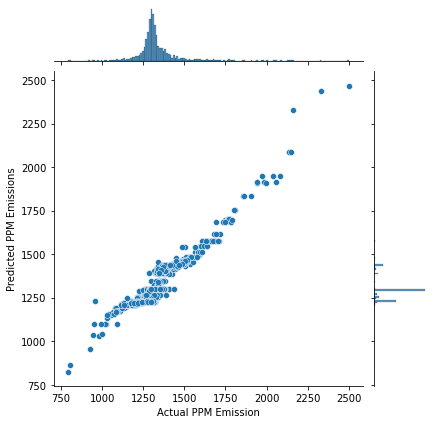

In [45]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# Gradient Boosting Regressor

In [46]:
%%time
Gra_model = GradientBoostingRegressor()
Gra_model_cv_scores = cross_val_score(Gra_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
Gra_model_cv_scores.mean()

Wall time: 4.37 s


-310.37104425484625

In [47]:
Gra_model.fit(X_train,Y_train)

GradientBoostingRegressor()

In [48]:
Y_predict.shape

(2000, 1)

In [49]:
mean_absolute_error(Y_test,Y_predict)

32.489286473360316

In [50]:
mean_squared_error(Y_test,Y_predict)

1720.7071402497804

In [51]:
r2_score(Y_test,Y_predict)

0.8802026830080375

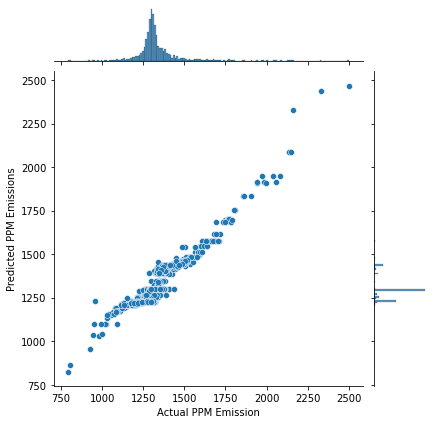

In [52]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# DecisionTree Regressor

In [53]:
dtree_model = DecisionTreeRegressor()
dtree_model_cv_scores = cross_val_score(dtree_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error')
dtree_model_cv_scores.mean()

-764.3915140999999

In [54]:
dtree_model.fit(X_train,Y_train)

DecisionTreeRegressor()

In [55]:
Y_predict = dtree_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [56]:
mean_absolute_error(Y_test,Y_predict)

19.51993

In [57]:
mean_squared_error(Y_test,Y_predict)

673.1526371000001

In [58]:
r2_score(Y_test,Y_predict)

0.9531344538740404

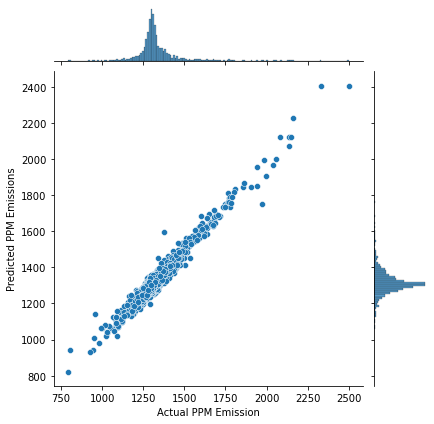

In [59]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

## hyperparameter tuning

In [62]:
%%time
dtree_reg_model = DecisionTreeRegressor()

dtree_clf_params = {
    'splitter':['best', 'random'],
    'criterion':['mse', 'mae'],
    'max_depth':[None,5,10,15,20,30,50,70],
    'min_samples_leaf':[1,2,5,10,15,20],
    'min_samples_split':[2,5,10,15,20]
}

dtree_reg_random_search = RandomizedSearchCV(dtree_reg_model,param_distributions=dtree_clf_params,
                                             cv = 5, n_iter=10,scoring='neg_mean_squared_error')

dtree_reg_random_search.fit(X_train,Y_train)

Wall time: 1min


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [None, 5, 10, 15, 20, 30,
                                                      50, 70],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'splitter': ['best', 'random']},
                   scoring='neg_mean_squared_error')

In [63]:
report(dtree_reg_random_search.cv_results_,3)

Model with rank: 1
Mean validation score: -590.022551 (std: 145.064904)
Parameters: {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'mse'}

Model with rank: 2
Mean validation score: -646.610647 (std: 130.741606)
Parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50, 'criterion': 'mse'}

Model with rank: 3
Mean validation score: -662.811343 (std: 180.020882)
Parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 70, 'criterion': 'mae'}



In [64]:
dtree_reg = dtree_reg_random_search.best_estimator_

In [65]:
dtree_reg.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=15)

In [66]:
Y_predict = dtree_reg.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [67]:
mean_absolute_error(Y_test,Y_predict)

14.789796442749658

In [68]:
mean_squared_error(Y_test,Y_predict)

492.1864588395166

In [69]:
r2_score(Y_test,Y_predict)

0.9657334965087726

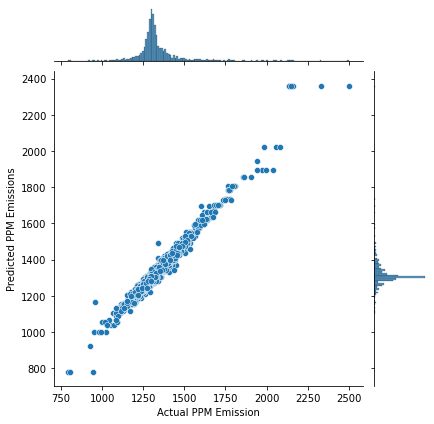

In [70]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# RandomForest Regressor

In [71]:
rf_dtree_model = RandomForestRegressor()
rf_dtree_model_cv_scores = cross_val_score(rf_dtree_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error')
rf_dtree_model_cv_scores.mean()

-384.41946071174783

In [72]:
rf_dtree_model.fit(X_train,Y_train)

RandomForestRegressor()

In [73]:
Y_predict = rf_dtree_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [74]:
mean_absolute_error(Y_test,Y_predict)

13.138057599999993

In [75]:
mean_squared_error(Y_test,Y_predict)

316.7729986441597

In [76]:
r2_score(Y_test,Y_predict)

0.9779459534714546

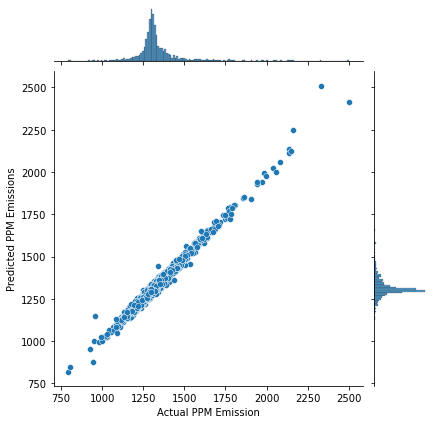

In [77]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

In [79]:
%%time
rf_reg_model = RandomForestRegressor()

rf_reg_params = {
    'n_estimators':[100,200,300,500,700,1000], #number of individual decision trees to be created
    'max_features': ['auto','sqrt','log2'], #how many features would be available at a split
    'bootstrap': [True, False], #should different data subsets go in or not
    'criterion':['mse', 'mae'],
    'max_depth':[None,5,10,15,20,30,50,70],
    'min_samples_leaf':[1,2,5,10,15,20],
    'min_samples_split':[2,5,10,15,20]
}

rf_reg_random_search = RandomizedSearchCV(rf_reg_model,param_distributions=rf_reg_params,
                                             cv = 2,
                                    n_iter=5,
                                    scoring='neg_mean_squared_error',
                                    n_jobs=-1,verbose=1)

rf_reg_random_search.fit(X_train,Y_train)
report(rf_reg_random_search.cv_results_,3)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Model with rank: 1
Mean validation score: -455.538167 (std: 67.939449)
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'mae', 'bootstrap': True}

Model with rank: 2
Mean validation score: -1104.128278 (std: 154.242372)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'auto', 'max_depth': 15, 'criterion': 'mae', 'bootstrap': True}

Model with rank: 3
Mean validation score: -1173.523066 (std: 36.392225)
Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'mae', 'bootstrap': False}

Wall time: 15min 35s


In [80]:
rf_reg = rf_reg_random_search.best_estimator_

In [81]:
rf_reg.fit(X_train,Y_train)

RandomForestRegressor(criterion='mae', max_depth=20, min_samples_split=5,
                      n_estimators=200)

In [82]:
Y_predict = rf_reg.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [83]:
mean_absolute_error(Y_test,Y_predict)

13.169754774999994

In [84]:
mean_squared_error(Y_test,Y_predict)

323.3810801634235

In [85]:
r2_score(Y_test,Y_predict)

0.9774858923617198

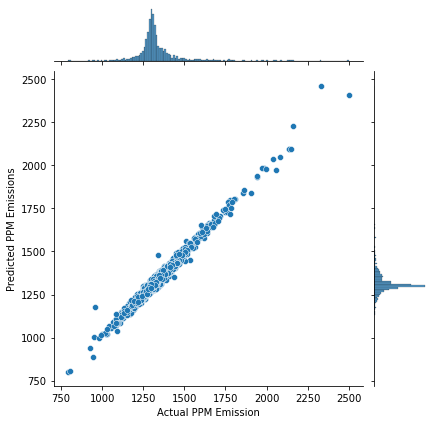

In [86]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# ExtraTrees Regressor

In [87]:
et_dtree_model = ExtraTreesRegressor()
et_dtree_model_cv_scores = cross_val_score(et_dtree_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error')
et_dtree_model_cv_scores.mean()

-320.80703691784777

In [88]:
et_dtree_model.fit(X_train,Y_train)

ExtraTreesRegressor()

In [89]:
Y_predict = et_dtree_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])


In [90]:
mean_absolute_error(Y_test,Y_predict)

12.781987850000005

In [91]:
mean_squared_error(Y_test,Y_predict)

271.1138371553952

In [92]:
r2_score(Y_test,Y_predict)

0.981124789029528

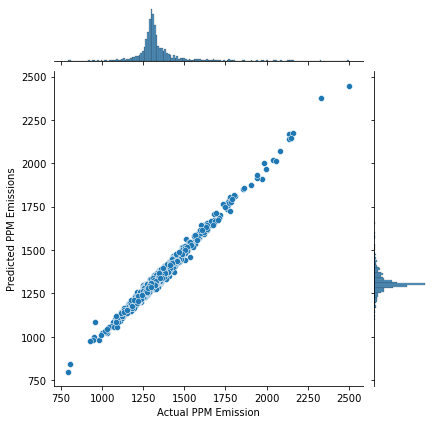

In [93]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

In [95]:
%%time
etree_reg_model = ExtraTreesRegressor()

etree_reg_params = {
    'n_estimators':[100,200,300,500,700,1000], #number of individual decision trees to be created
    'max_features': ['auto','sqrt','log2'], #how many features would be available at a split
    'bootstrap': [True, False], #should different data subsets go in or not
    'criterion':['mse', 'mae'],
    'max_depth':[None,5,10,15,20,30,50,70],
    'min_samples_leaf':[1,2,5,10,15,20],
    'min_samples_split':[2,5,10,15,20]
}

etree_reg_random_search = RandomizedSearchCV(etree_reg_model,param_distributions=etree_reg_params,
                                             cv = 2, n_iter=5,scoring='neg_mean_squared_error',n_jobs=-1,verbose=1)

etree_reg_random_search.fit(X_train,Y_train)
report(etree_reg_random_search.cv_results_,3)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Model with rank: 1
Mean validation score: -2434.239113 (std: 35.729659)
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'mse', 'bootstrap': True}

Model with rank: 2
Mean validation score: -2441.340375 (std: 11.712648)
Parameters: {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'mse', 'bootstrap': False}

Model with rank: 3
Mean validation score: -4718.286663 (std: 95.048243)
Parameters: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 70, 'criterion': 'mse', 'bootstrap': True}

Wall time: 31.8 s


In [96]:
etree_reg = etree_reg_random_search.best_estimator_

In [97]:
etree_reg.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=50, max_features='log2',
                    n_estimators=200)

In [98]:
Y_predict = etree_reg.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [99]:
mean_absolute_error(Y_test,Y_predict)

25.746257525000022

In [100]:
mean_squared_error(Y_test,Y_predict)

2298.3662597578336

In [101]:
r2_score(Y_test,Y_predict)

0.8399854891379879

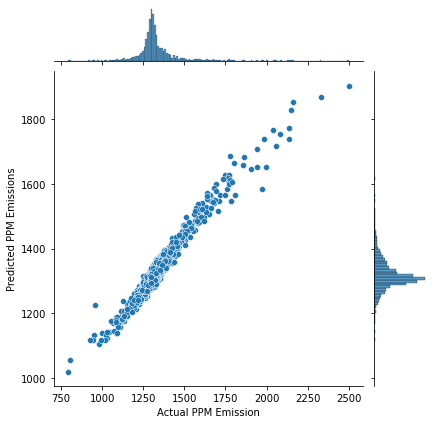

In [102]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# LGBM Regressor

In [103]:
%%time
lgm_model = LGBMRegressor()
lgm_model_cv_scores = cross_val_score(lgm_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
lgm_model_cv_scores.mean()

Wall time: 2.11 s


-570.2975154480677

In [104]:
lgm_model.fit(X_train,Y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score 1325.652270


LGBMRegressor()

In [105]:
Y_predict = lgm_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [106]:
mean_absolute_error(Y_test,Y_predict)

13.571499451828583

In [107]:
mean_squared_error(Y_test,Y_predict)

407.63698569042805

In [108]:
r2_score(Y_test,Y_predict)

0.9716199136679845

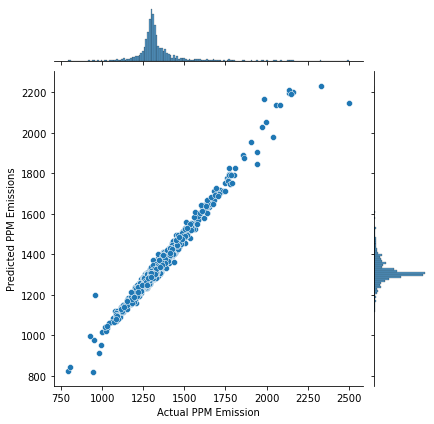

In [109]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# CatBoost Regressor

In [110]:
%%time
cat_model = CatBoostRegressor()
cat_model_cv_scores = cross_val_score(cat_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
cat_model_cv_scores.mean()

Wall time: 10.4 s


-536.0652489931542

In [111]:
cat_model.fit(X_train,Y_train)

Learning rate set to 0.056868
0:	learn: 109.4887520	total: 126ms	remaining: 2m 5s
1:	learn: 104.6107478	total: 129ms	remaining: 1m 4s
2:	learn: 100.1966244	total: 131ms	remaining: 43.7s
3:	learn: 96.1164420	total: 134ms	remaining: 33.4s
4:	learn: 91.9787811	total: 137ms	remaining: 27.2s
5:	learn: 87.9229101	total: 140ms	remaining: 23.2s
6:	learn: 84.0753965	total: 143ms	remaining: 20.2s
7:	learn: 80.3948842	total: 146ms	remaining: 18.1s
8:	learn: 77.0442368	total: 149ms	remaining: 16.4s
9:	learn: 73.9646152	total: 152ms	remaining: 15s
10:	learn: 71.1815800	total: 155ms	remaining: 13.9s
11:	learn: 68.3354553	total: 158ms	remaining: 13s
12:	learn: 65.5096578	total: 161ms	remaining: 12.2s
13:	learn: 62.9633572	total: 164ms	remaining: 11.6s
14:	learn: 60.4454023	total: 168ms	remaining: 11s
15:	learn: 58.2942771	total: 170ms	remaining: 10.5s
16:	learn: 56.1367301	total: 173ms	remaining: 10s
17:	learn: 54.0382413	total: 176ms	remaining: 9.6s
18:	learn: 52.1197413	total: 179ms	remaining: 9.22

In [112]:
Y_predict = cat_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [113]:
mean_absolute_error(Y_test,Y_predict)

13.488316801655126

In [114]:
mean_squared_error(Y_test,Y_predict)

441.92359413312573

In [115]:
r2_score(Y_test,Y_predict)

0.9692328463954021

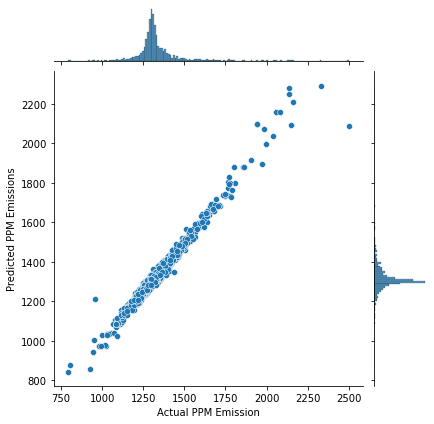

In [116]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# XGB Regressor

In [117]:
%%time
xgb_model = XGBRegressor()
xgb_model_cv_scores = cross_val_score(xgb_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1)
xgb_model_cv_scores.mean()

Wall time: 2.38 s


-602.2898411674728

In [118]:
xgb_model.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [119]:
Y_predict = xgb_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [120]:
mean_absolute_error(Y_test,Y_predict)

14.7044182421875

In [121]:
mean_squared_error(Y_test,Y_predict)

518.3163007898288

In [122]:
r2_score(Y_test,Y_predict)

0.9639143113111003

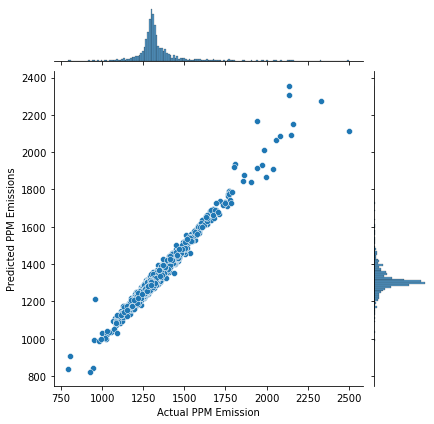

In [123]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

# Stacking Regressor

In [124]:
estimators = [
    ('et_dtree_model',et_dtree_model),
    ('rf_dtree_model',rf_dtree_model),
    ('etree_reg_model',etree_reg_model),
    ('lgm_model',lgm_model),
]

stack_reg_model = StackingRegressor(estimators=estimators,final_estimator=SVR(kernel = 'linear',degree = 1,epsilon = 0.05))

# stack_cv_scores= cross_val_score(stack_reg_model,X_train,Y_train,cv=5,scoring='neg_mean_squared_error')
# stack_cv_scores.mean()

In [125]:
%%time
stack_reg_model.fit(X_train,Y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] Start training from score 1325.652270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 20
[LightGBM] [Info] Start training from score 1324.628933
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 20
[LightGBM] [Info] Start 

StackingRegressor(estimators=[('et_dtree_model', ExtraTreesRegressor()),
                              ('rf_dtree_model', RandomForestRegressor()),
                              ('etree_reg_model', ExtraTreesRegressor()),
                              ('lgm_model', LGBMRegressor())],
                  final_estimator=SVR(degree=1, epsilon=0.05, kernel='linear'))

In [126]:
Y_predict = stack_reg_model.predict(X_test)
Y_predict =  pd.DataFrame(data = Y_predict , columns = ['Predicted PPM Emissions'])
Y_predict.shape

(2000, 1)

In [127]:
mean_absolute_error(Y_test,Y_predict)

12.722524166484368

In [128]:
mean_squared_error(Y_test,Y_predict)

271.5791062534908

In [129]:
r2_score(Y_test,Y_predict)

0.9810923965390644

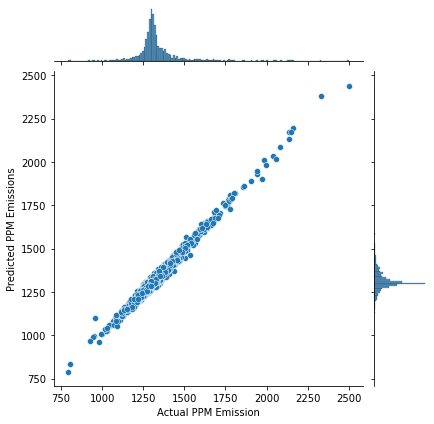

In [130]:
sb.jointplot(data = pd.concat([Y_test,Y_predict],axis  = 1 ), x = 'Actual PPM Emission' , y ='Predicted PPM Emissions')

In [138]:
et_dtree_model.feature_importances_

array([0.00140521, 0.00113425, 0.0012878 , 0.00125916, 0.00114518,
       0.00145158, 0.00116018, 0.00130419, 0.22559731, 0.00132613,
       0.75181332, 0.00125111, 0.00143602, 0.00130693, 0.00122615,
       0.0011322 , 0.00117584, 0.00117186, 0.00114103, 0.00127454])

In [173]:
def feature_imp_rank(model,x_data):
    #creating a simple dataframe with column names and importances
    feature_importance_table = pd.DataFrame({
        'Feature': x_data.columns,
        'Importance': model.feature_importances_
    })
    
    #sorting based on importance
    feature_importance_table.sort_values(by='Importance', ascending=False,inplace=True)
    
    #gettnig a relative importance = importance of a variable/overall sum of importances
    feature_importance_table['Importance'] = (feature_importance_table['Importance']/feature_importance_table['Importance'].sum())*100

    print('\nFeature Importance \n')
    print(feature_importance_table)


def prem_feature_imp(model,x_data,y_data):
    perm_importances = permutation_importance(model, x_data,y_data)
    perm_importance_table = pd.DataFrame({
    'Feature': x_data.columns,
    'Importance': perm_importances.importances_mean
    })

    perm_importance_table.sort_values(by='Importance', ascending=False,inplace=True)
    
    perm_importance_table['Importance'] = (perm_importance_table['Importance']/perm_importance_table['Importance'].sum())*100

    print('\nPremutation Feature Importance \n')
    print(perm_importance_table)

In [174]:
feature_imp_rank(et_dtree_model,X_train)
prem_feature_imp(et_dtree_model,X_train,Y_train)


Feature Importance 

     Feature  Importance
10  gear_sp1   75.181332
8   fuel_sp4   22.559731
5   fuel_sp1    0.145158
12  gear_sp3    0.143602
0    eng_sp1    0.140521
9   fuel_sp5    0.132613
13  gear_sp4    0.130693
7   fuel_sp3    0.130419
2    eng_sp3    0.128780
19   nav_sp5    0.127454
3    eng_sp4    0.125916
11  gear_sp2    0.125111
14  gear_sp5    0.122615
16   nav_sp2    0.117584
17   nav_sp3    0.117186
6   fuel_sp2    0.116018
4    eng_sp5    0.114518
18   nav_sp4    0.114103
1    eng_sp2    0.113425
15   nav_sp1    0.113220

Premutation Feature Importance 

     Feature  Importance
10  gear_sp1   76.612575
8   fuel_sp4   23.022383
9   fuel_sp5    0.055885
5   fuel_sp1    0.020805
2    eng_sp3    0.019347
14  gear_sp5    0.019089
1    eng_sp2    0.019029
16   nav_sp2    0.018939
11  gear_sp2    0.018937
18   nav_sp4    0.018898
7   fuel_sp3    0.018198
4    eng_sp5    0.018148
19   nav_sp5    0.018086
0    eng_sp1    0.017885
17   nav_sp3    0.017780
12  gear_sp3    0.0

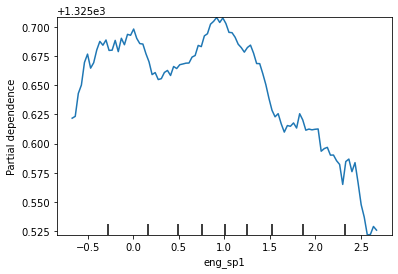

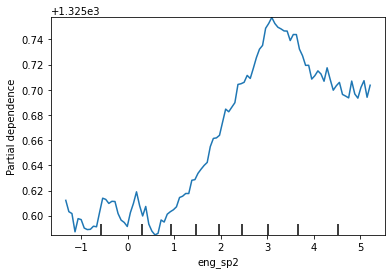

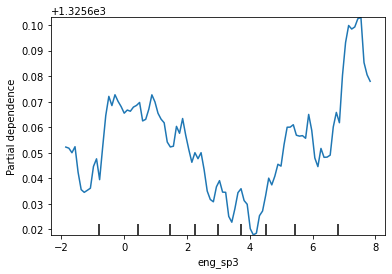

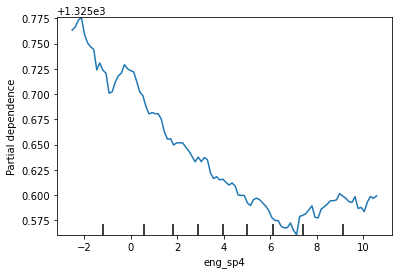

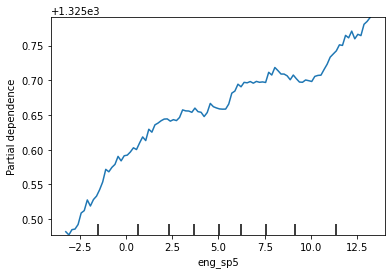

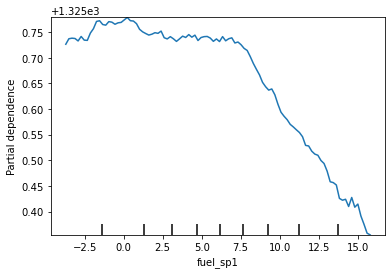

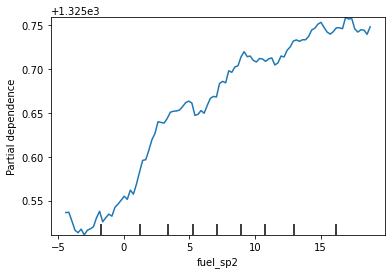

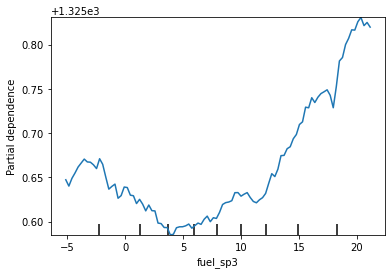

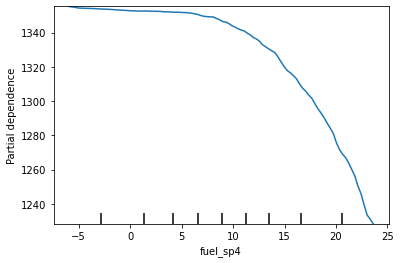

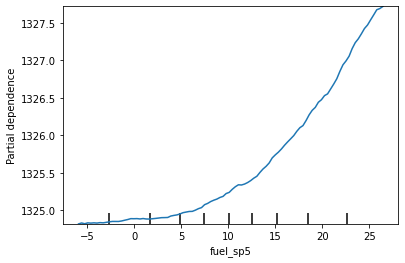

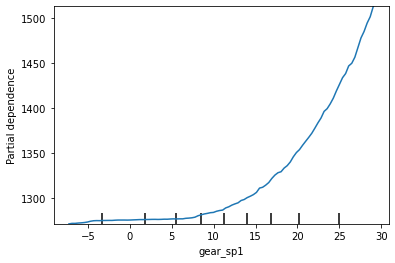

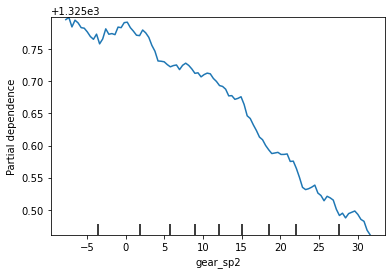

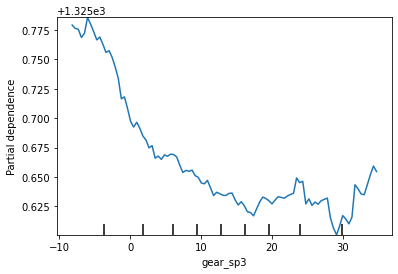

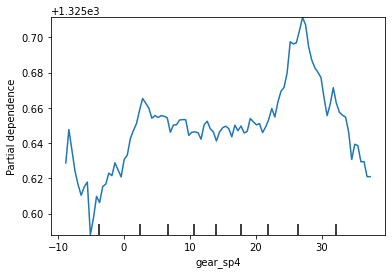

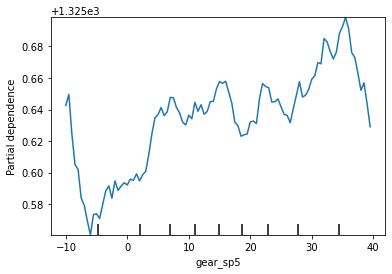

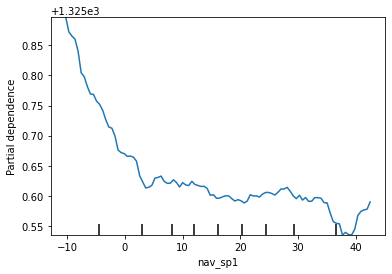

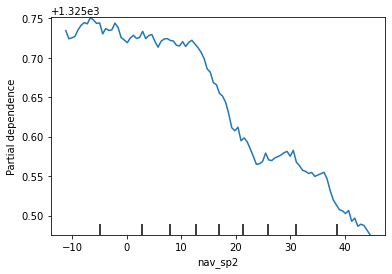

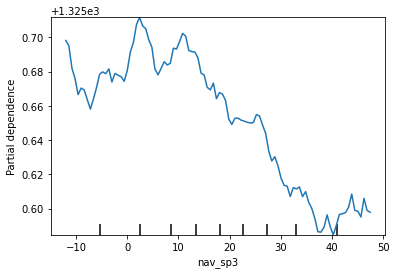

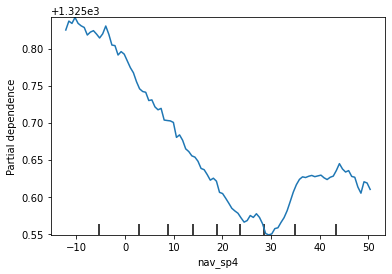

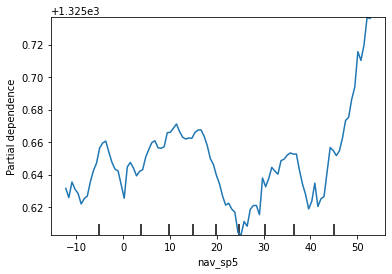

In [187]:
for col in list(X_train.columns):
    disp1 = plot_partial_dependence(et_dtree_model, X_train, [col])
    plt.show()